In [166]:
using Plots
using StatsBase
using Distributions
using Random
using QuadGK
using LinearAlgebra
using Combinatorics
using BenchmarkTools
using Printf
using Parameters

#include("MyModuleILM.jl")
#import .MyModuleILM

include("../matrices/matrix.jl")
include("../density/instanton_density.jl")
include("../action/action.jl")
include("../fermion/fermion.jl")
include("../HMC/hmc.jl")
include("../HMC/simple_mp.jl")
include("../plot/plot.jl")


#versioninfo()

0. 表記に関して

struct              -> キャメルケース

structの構造を持つ引数 -> 大文字で始まる文字列

関数                 -> 小文字

１．メインのILMの計算コード

1.A 計算のセットアップ 

    (a) Modelparams = ModelParams() でモデル内のパラメータを設定する：
    Nc, Nf, Λ, nI, nA, N, mag, A, g, gauge

    (b) choose_gauge_field!() でインスタントンの数，ゲージ，フレーバーを決める

    (c) ColorWorkSpace, ParamsofILM で計算に必要な変数とワークスペースを確保する．

1.B 配位の生成




    


In [187]:
#-----------------------------------------------------------------------------------------------------------------------#
#= HMC法の計算を実行する． =#

using Plots
using Parameters
using Distributions
using Random
using LinearAlgebra
using Combinatorics
using QuadGK

include("../matrices/matrix.jl")
include("../density/instanton_density.jl")
include("../action/action.jl")
include("../fermion/fermion.jl")
include("../HMC/hmc.jl")
include("../HMC/simple_mp.jl")
include("../plot/plot.jl")

# model parameters -----------------------------------------------------------------------------------------------------#
Modelparams = ModelParams(0,0,0,  0,0,0,  0,0,0, "gauge")                   #struct呼び出し
choose_gauge_field!(Modelparams,3,3,gauge="SU(2)",flavor=1)  #インスタントン数，ゲージ場のカラー，フレーバー数の選択


#カラー空間での計算を行うワークスペースの確保，初期化
@with_kw mutable struct ColorWorkSpace
    u::Array{ComplexF64,1}   = zeros(ComplexF64,4)
    sigma::Array{Any,1}      = make_sigma()
    lambda::Array{Any,1}     = make_lambda()
    tem::Array{ComplexF64,2} = zeros(ComplexF64,2,2)
    res::Array{ComplexF64,2} = zeros(ComplexF64,2,2)
end

#初期配位，共役運動量の初期化 -----------------------------------------------------------------------------------------------#
@with_kw mutable struct ParamsofILM
    ρ::Array{Float64,1}     = (1/Modelparams.Λ)* Modelparams.mag * ones(Float64, Modelparams.nI + Modelparams.nA)
    θ::Array{Float64,2}     = rand(Float64, Modelparams.nI + Modelparams.nA, Modelparams.Nc)
    z::Array{Float64,2}     = rand(Float64,  Modelparams.nI + Modelparams.nA, 4) 
    conjρ::Array{Float64,1} = rand(Normal(0,1), Modelparams.nI + Modelparams.nA)
    conjθ::Array{Float64,2} = rand(Normal(0,1), Modelparams.nI + Modelparams.nA, Modelparams.Nc)
    conjz::Array{Float64,2} = rand(Normal(0,1), Modelparams.nI + Modelparams.nA, 4)
end

ParamsofHMC    = ParamsofILM()
BackupofHMC    = ParamsofILM()
Colorworkspace = ColorWorkSpace()
# Sigma  :OK
# u      :OK
# lambda :OK
# tem    :OK
# res    :OK
# lambda :OK
# theta  :OK



#conjρの出力確認
#=
@show ParamsofHMC.conjρ[1]
@show ParamsofHMC.conjρ[2]
@show ParamsofHMC.conjρ[3]
@show ParamsofHMC.conjρ[4]
=#

#conjθの出力確認
#=
@show ParamsofHMC.conjθ[1, 1]
@show ParamsofHMC.conjθ[1, 2]
@show ParamsofHMC.conjθ[1, 3]
@show ParamsofHMC.conjθ[2, 1]
@show ParamsofHMC.conjθ[2, 2]
@show ParamsofHMC.conjθ[2, 3]
@show ParamsofHMC.conjθ[3, 1]
@show ParamsofHMC.conjθ[3, 2]
@show ParamsofHMC.conjθ[3, 3]
=#

#=
@show ParamsofHMC.conjθ[4,1:3]
@show dot(ParamsofHMC.conjθ[4,1:3],ParamsofHMC.conjθ[4,1:3])
@show dot(ParamsofHMC.conjθ[4,1:3],ParamsofHMC.conjθ[4,1:3]) == ParamsofHMC.conjθ[4,1]*ParamsofHMC.conjθ[4,1] + ParamsofHMC.conjθ[4,2]*ParamsofHMC.conjθ[4,2] + ParamsofHMC.conjθ[4,3]*ParamsofHMC.conjθ[4,3]

@show ParamsofHMC.conjθ
=#
#=
@show ParamsofHMC.conjz[1]
@show ParamsofHMC.conjz
=#

#初期時刻 tau = 0.0 でのハミルトニアンを計算 ----------------------------------------------------------------------------------#
Hini = 0.0
Hfin = 0.0
@time Hini = hamiltonian(ParamsofHMC,Modelparams,Colorworkspace)
#-------------------------------------------------------------------------------------------------------------------------#

#分子軌道法により，パラメータの時間発展を計算 -----------------------------------------------------------------------------------#
#BackupofHMC = deepcopy(ParamsofHMC) #中身をそのままコピーしたバックアップを作成
# 2021-10-4 HMCでの変数更新のテスト
#ParamsofHMC.conjρ[1] = -0.2
#ParamsofHMC.ρ[1]     = 0.0025
#@show ParamsofHMC.conjρ[1]
#@show ParamsofHMC.ρ[1]
#molecular_dynamics_rho!(1,ParamsofHMC,Modelparams,Colorworkspace)


#@show ParamsofHMC.ρ[1]
#@time mp_update!(1, ParamsofHMC, Modelparams)
#@show ParamsofHMC.ρ[1]



#mp_check()

# molecular_dynamics_theta!(N, k, ParamsofHMC,Modelparams,Colorworkspace)
#mp_check()

# molecular_dynamics_z!(N, k, ParamsofHMC,Modelparams,Colorworkspace)
#mp_check()

#-------------------------------------------
#@time Hfin = hamiltonian(ParamsofHMC,Modelparams,Colorworkspace)


#cal_force_rho(0.0025, 2, ParamsofHMC, Modelparams, Colorworkspace)


#===========================test========================================#

#=======================================================================#
#=
@show ParamsofHMC.θ[1]
@show ParamsofHMC.θ[1,1:3]
@show ParamsofHMC.z[1,1:4]
ParamsofHMC.z[1,1:4] .= 1.0
@show ParamsofHMC.z[1,1:4]
ParamsofHMC.θ
ParamsofHMC.z
=#
#===========================plot=======================================#
#@show ParamsofHMC.ρ[1] 
#@show ParamsofHMC.ρ[2]  

# overlap elements plot用コード
#=
set_rho1 = 1.0
set_rho2 = 2.0

plot_overlap_emlements(10e-4, 5.0, set_rho1, set_rho2, ParamsofHMC, Modelparams, Colorworkspace, type="sl1", re=0,sample=1000)
plot_overlap_emlements(10e-4, 5.0, set_rho1, set_rho2, ParamsofHMC, Modelparams, Colorworkspace, type="sl2", re=1)
plot_overlap_emlements(10e-4, 5.0, set_rho1, set_rho2, ParamsofHMC, Modelparams, Colorworkspace, type="sl3", re=2)
plot_overlap_emlements(10e-4, 5.0, set_rho1, set_rho2, ParamsofHMC, Modelparams, Colorworkspace, type="sum", re=3)
=#
#savefig("../FIGS/overlap_elements_rho_1.png")
#savefig("../FIGS/overlap_elements_rho_2.png")
#savefig("../FIGS/overlap_elements_rho_1-2.png")

#=======================================================================#
# fermion det の確認
#=
@time mass_matrix(4,Modelparams)
@time dirac_ope_matrix(ParamsofHMC,Modelparams,Colorworkspace)
@time det_total_product(3,ParamsofHMC,Modelparams,Colorworkspace)

@time tr_log_fermion(3,ParamsofHMC,Modelparams,Colorworkspace)
=#

#=
display(ParamsofHMC.θ)
ParamsofHMC.θ[1,2]
=#
#=======================================================================#



#@show dudθ(3, 1, 4, 1, 1, ParamsofHMC, Modelparams, Colorworkspace)
#@show action_stream_dtheta(1,2,1,2, ParamsofHMC, Modelparams, Colorworkspace)

#@show ParamsofHMC.z
#@show action_core_dz(1, 2, 4, 2, ParamsofHMC, Modelparams, Colorworkspace)
#@show action_stream_dz(1, 2, 4, 2, ParamsofHMC, Modelparams, Colorworkspace)



----- hamiltonian Calc. --------------------------------------------------------------------
test(1) : [correct gauge?] passed!
sum_momentum = 21.332582043096004
test(2) : [finish calculating momenta?] passed!
sum_action = -188.77352656438217
density part passed!
action_int part passed!
sum_action = -188.7735265561046 + 0.0im
test(3) : [finish calculating action?] passed!
----- hamiltonian Calc. End ----------------------------------------------------------------
hamiltonian : -167.4409445130086 + 0.0im
  0.325245 seconds (947.93 k allocations: 55.596 MiB, 4.68% gc time, 98.61% compilation time)


-167.4409445130086 + 0.0im

In [91]:
#行列とトレース，行列式に関する公式の確認

TestA = [
    1 2
    3 4
]

TestB = [
    0 3+2im
    3-2im 0
]

TestC = exp(TestB)

@show det(TestB)
@show tr(log(TestB))
@show log(abs(det(TestB)))
@show exp(log(abs(det(TestB))))
@show exp(tr(log(TestB)))


@show log(im) == pi * im/2

det(TestB) = -13.0 - 0.0im
tr(log(TestB)) = 2.5649493574615363 + 3.1415926535897927im
log(abs(det(TestB))) = 2.5649493574615367
exp(log(abs(det(TestB)))) = 13.0
exp(tr(log(TestB))) = -12.999999999999995 + 7.365200566942371e-15im
log(im) == (pi * im) / 2 = true


true

In [96]:
z_complex = Complex(2,2)
real(z_complex)

2

In [155]:
using Random
using Distributions

rand_num = [0.0]
rand!(Uniform(-1,1),rand_num)


1-element Vector{Float64}:
 -0.6344981111124479

$$
\det (e^A) = e^{\textrm{tr} A} \\
\det (A) = e^{\textrm{tr}(\log A)} \\
\textrm{tr}(\log A) = \log (\det (A))
$$
$$
6 \int_0^{\infty} \frac{x^{3/2}}{(x+1/\lambda)^{3/2}(x+\lambda)^{5/2}}dx 
= \frac{3 \pi}{8} \frac{\lambda^{3/2}}{[1+\frac{5}{4}(\lambda^2-1) + (3\pi/32)^{4/3}(\lambda^2-1)^2]^{3/4}}
$$

論文の図と合致するのはNo2の方．

マークダウンにメモを残します．


log(xLambda) < 0
の制限により，cal_force_rhoの計算が大きく制限される．

また，cal_forceの返り値が実数であるという条件を課すと，計算が進まなくなる．
（全てのステップで log(xLambda)<0を満たす必要があるため．）

これを解決するためには，

(a) インスタント密度（およびその微分）の表式の確認

    'tHooftの論文を参照しているが，まだ確認できていない．

(b) HMC法を用いるのではなく，純粋なメトロポリス法を用いる

    （変数の提案の方法がリープフロッグ方程式を用いるか，一様乱数を用いるかの違い）
    これにより，作用の微分計算を行わずに計算を実行できる．
    しかし，計算コストが大きくなる．これは，自己相関が小さくなるまでに配位の更新回数が必要になるため．

(c) 平均場近似の方法による計算の確認も必要．

(d) 線形シグマ模型，NJL模型における，エータの質量計算，その問題点を把握しておく必要がある．


2021-10-8 追記

計算するもの
    HMC

    ρ,θ,z の更新アルゴリズム（MP法）

    ただし，ρの更新方法は単純なMP法になる可能性あり．

    それぞれがHMC法を用いる場合に計算する必要があるもの．

ρ：微分
    density

    S_core      手計算：済      実装：済

    S_stream    手計算：済      実装：済

    det(iD-m)   手計算：未      実装：未

θ：微分

    S_core      手計算：済      実装：未

    S_stream    手計算：済      実装：未

    det(iD-m)   手計算：未      実装：未

z：微分

    S_core      手計算：済      実装：未

    S_stream    手計算：済      実装：未
    
    det(iD-m)   手計算：未      実装：未

フェルミオン行列式の計算をトレースしておきたい．
ゲージ場の経路積分についても見ておく必要がある．




    


In [171]:

#運動エネルギー

T = 10  # s
L = 30  # m
V = L/T # m/s
M = 10  # kg
E = 0.5M*V^2 # kg m/s^2

tau = 2   # スケール因子
println("=========Before scaling=======")
println("T = $T    [s]")
println("L = $L    [m]")
println("V = $V   [m/s]")
println("M = $M    [kg]")
println("E = $E  [kg m^2/s^2]")

println("==============================")
println("scale factor tau = $tau [s]")
println("scaling : t=T/tau")
println("=========After scaling========")
t = T/tau   # 無次元：tを基準とした単位系
l = L
v = l/t # 無次元の時間で測った速度．
m = M
e = 0.5*m*v^2
println("t = $t   [1]")
println("l = $l    [m]")
println("v = $v   [m]")
println("m = $m    [kg]")
println("e = $e [kg m^2]")
println("==============================")

=========Before scaling=======
T = 10    [s]
L = 30    [m]
V = 3.0   [m/s]
M = 10    [kg]
E = 45.0  [kg m^2/s^2]
scale factor tau = 2 [s]
scaling : t=T/tau
=========After scaling========
t = 5.0   [1]
l = 30    [m]
v = 6.0   [m]
m = 10    [kg]
e = 180.0 [kg m^2]


In [219]:

using StaticArrays

test_overlap  = SMatrix{2,3}(1,2,3,4,5,6)
test_overlap2 = @SMatrix [1 2 3 ; 4 5 6] 
test_overlap3 = @MMatrix [1 2 3 ; 4 5 6] 

test_overlap4 = test_overlap2'

display(test_overlap3)
display(test_overlap4)

test_overlap3[1,2] = 7.0

display(test_overlap3)

embed = @MMatrix zeros(5,5)

embed[1:2, 3:5] = test_overlap3

display(embed)

embed[3:5, 1:2] = test_overlap4

display(embed)

@show det(embed)

@time mass_matrix = diagm([1,1,1,1,1])

embed += mass_matrix

display(embed)

@show det(embed)

2×3 MMatrix{2, 3, Int64, 6} with indices SOneTo(2)×SOneTo(3):
 1  2  3
 4  5  6

3×2 SMatrix{3, 2, Int64, 6} with indices SOneTo(3)×SOneTo(2):
 1  4
 2  5
 3  6

2×3 MMatrix{2, 3, Int64, 6} with indices SOneTo(2)×SOneTo(3):
 1  7  3
 4  5  6

5×5 MMatrix{5, 5, Float64, 25} with indices SOneTo(5)×SOneTo(5):
 0.0  0.0  1.0  7.0  3.0
 0.0  0.0  4.0  5.0  6.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0

5×5 MMatrix{5, 5, Float64, 25} with indices SOneTo(5)×SOneTo(5):
 0.0  0.0  1.0  7.0  3.0
 0.0  0.0  4.0  5.0  6.0
 1.0  4.0  0.0  0.0  0.0
 2.0  5.0  0.0  0.0  0.0
 3.0  6.0  0.0  0.0  0.0

5×5 MMatrix{5, 5, Float64, 25} with indices SOneTo(5)×SOneTo(5):
 1.0  0.0  1.0  7.0  3.0
 0.0  1.0  4.0  5.0  6.0
 1.0  4.0  1.0  0.0  0.0
 2.0  5.0  0.0  1.0  0.0
 3.0  6.0  0.0  0.0  1.0

det(embed) = -0.0
  0.000008 seconds (2 allocations: 416 bytes)
det(embed) = -76.00000000000001


-76.00000000000001

In [350]:
R = 1.0

p1=[1.0,1.0]
p_ave1=sqrt(p1[1]*p1[2])
p2=[2.0,2.0]
p_ave2=sqrt(p2[1]*p2[2])

@show p1
@show p2

@show p_ave1
@show p_ave2

ratio1 = (R^2 + p1[1]^2 + p1[2]^2)/(p1[1]*p1[2])
ratio2 = (R^2 + p2[1]^2 + p2[2]^2)/(p2[1]*p2[2])

res1 = 0.5*ratio1 + 0.5*sqrt(ratio1^2-4)
res2 = 0.5*ratio2 + 0.5*sqrt(ratio2^2-4)

@show ratio1
@show ratio2

println("====before scaing====")
@show res1
@show res2
println("=====================")
r1 = R/p_ave1
r2 = R/p_ave2
@. p1 = p1/p_ave1
@. p2 = p2/p_ave2

@show r1 
@show r2 
@show p1
@show p2

ratio1 = (r1^2 + p1[1]^2 + p1[2]^2)/(p1[1]*p1[2])
ratio2 = (r2^2 + p2[1]^2 + p2[2]^2)/(p2[1]*p2[2])

res1 = 0.5*ratio1 + 0.5*sqrt(ratio1^2-4)
res2 = 0.5*ratio2 + 0.5*sqrt(ratio2^2-4)

@show ratio1
@show ratio2

println("====after scaing=====")
@show res1
@show res2
println("=====================")
#=
プライム付きの変数とプライム無しの変数のどちらで計算しても結果が同じということ．
異なるrhoに対しては異なる値を与える．

=#

p1 = [1.0, 1.0]
p2 = [2.0, 2.0]
p_ave1 = 1.0
p_ave2 = 2.0
ratio1 = 3.0
ratio2 = 2.25
====before scaing====
res1 = 2.618033988749895
res2 = 1.6403882032022077
r1 = 1.0
r2 = 0.5
p1 = [1.0, 1.0]
p2 = [1.0, 1.0]
ratio1 = 3.0
ratio2 = 2.25
====after scaing=====
res1 = 2.618033988749895
res2 = 1.6403882032022077


scale1 = 1.224744871391589
scale2 = 2.449489742783178
ratio1_bef = 2.333333333333333
ratio2_bef = 6.208333333333333
ratio1 = 2.416666666666667
ratio2 = 6.416666666666667
ratio1_scl = 2.3333333333333335
ratio2_scl = 6.208333333333333


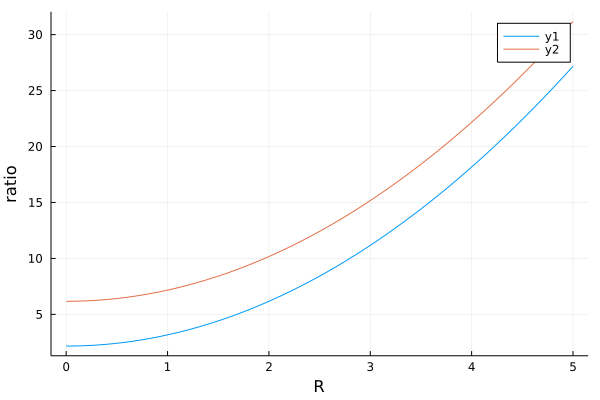

In [485]:
using Plots

ratio_part(R,i,a)          = R^2/(i*a) + i/a + a/i
conformal_parameter(R,i,a) = 0.5*ratio_part(R,i,a) + 0.5*sqrt(ratio_part(R,i,a)-4)
 
#スケールにlambdaが依存するか？
#異なるinputに対して，値が変化するかどうか

input1=[1,1.5]
R1 = 0.5
input2=[1,6.0]
R2 = 0.5

#before scaling
ratio1_bef = ratio_part(R1,input1[1],input1[2])
ratio2_bef = ratio_part(R1,input2[1],input2[2])

#scale factor 
scale1 = sqrt(input1[1]*input1[2])
scale2 = sqrt(input2[1]*input2[2])
@show scale1
@show scale2


#scaling 
scaled1 = input1 / scale1
scaled2 = input2 / scale2
R1_scaled = R1 / scale1
R2_scaled = R2 / scale2

# results
ratio1 = ratio_part(R1,scaled1[1],scaled1[2])
ratio2 = ratio_part(R2,scaled2[1],scaled2[2])

ratio1_scl = ratio_part(R1_scaled,scaled1[1],scaled1[2])
ratio2_scl = ratio_part(R2_scaled,scaled2[1],scaled2[2])

@show ratio1_bef
@show ratio2_bef

@show ratio1
@show ratio2

@show ratio1_scl
@show ratio2_scl

plot_r = range(0,5,length=1000)
plot_ratio1 = similar(plot_r)
plot_ratio2 = similar(plot_r)

@. plot_ratio1 = ratio_part(plot_r,scaled1[1],scaled1[2])
@. plot_ratio2 = ratio_part(plot_r,scaled2[1],scaled2[2])

plot(plot_r,plot_ratio1,
    xlabel="R"
)
plot!(plot_r,plot_ratio2,
    xlabel="R", ylabel="ratio"
)


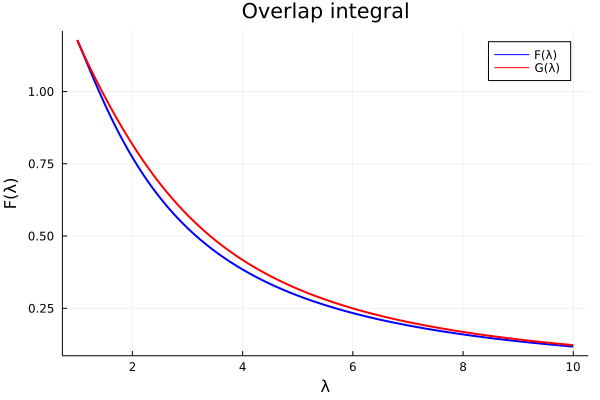

In [430]:
#F(lambda)とG(lambda)をプロットして，比較する
using Plots
using QuadGK

include("../plot/plot.jl")


plot_overlap_integral(1,10,type="F",re="false",sample=1000)
plot_overlap_integral(1,10,type="G",re="true",sample=1000)

# G(λ)の定義域は λ>=0.25ぐらい



In [417]:

c2  = (3pi/32)^(4/3)

x1_square = ((2*c2-1.25) + sqrt( (2*c2-1.25)^2 - 4*c2*(c2-0.25) ))/(2*c2)
@show x1_square
xi = sqrt(x1_square)
@show xi

x1_square = 0.062099853969908546
xi = 0.2491984228880844


0.2491984228880844

In [618]:
using Plots

ratio_part(R,i,a)          = R^2/(i*a) + i/a + a/i
conformal_parameter(R,i,a) = 0.5*ratio_part(R,i,a) + 0.5*sqrt(ratio_part(R,i,a)^2-4)

#====================================================================#
#conformal parameterに関して調べる

#@show conformal_parameter(1,0.1,0.1) 
#=
@show conformal_parameter(1,1,2.5)
@show conformal_parameter(1,6,3)
@show conformal_parameter(1,4,10)
=#
#3次元プロット
#=
mesh = 1000
xr = range(1,5,length=mesh)
yr = range(1,5,length=mesh)
conformal_map = zeros(mesh,mesh)

@. conformal_map = conformal_parameter(1, xr',yr)

surface(conformal_map)
=#


test_P(R,i,a)   = ( R/(i*a) ) * (conformal_parameter(R,i,a)^2+1)^(-2)
scaled_P(R,i,a) = ( R/(i*a) ) * (conformal_parameter(R,i,a)^2+1)^(-2)

rho1 = 1.0
rho2 = 3.0
r1   = 1.0
r2   = 3.0

#=
    #スケール前
    test_P1 = test_P(r1, rho1, rho1)
    test_P2 = test_P(r1, rho1, rho2)
    test_P3 = test_P(r2, rho1, rho1)
    test_P4 = test_P(r2, rho1, rho2)
    println("P1 = $test_P1  P2 = $test_P2  P3 = $test_P3  P4 = $test_P4")

    #スケール後
    scale1 = sqrt(rho1*rho1)
    scale2 = sqrt(rho1*rho2)

    test_Q1 = test_P(r1/scale1,rho1/scale1,rho1/scale1)
    test_Q2 = test_P(r1/scale2,rho1/scale2,rho2/scale2)
    test_Q3 = test_P(r2/scale1,rho1/scale1,rho1/scale1)
    test_Q4 = test_P(r2/scale2,rho1/scale2,rho2/scale2)
    println("Q1 = $test_Q1  Q2 = $test_Q2  Q3 = $test_Q3  Q4 = $test_Q4")

    #スケールを戻す

    test_R1 = test_Q1/scale1
    test_R2 = test_Q2/scale2
    test_R3 = test_Q3/scale1
    test_R4 = test_Q4/scale2
    println("R1 = $test_R1  R2 = $test_R2  R3 = $test_R3  R4 = $test_R4")


    #lambdaの値を確認
        #スケール前
    println("lanbda:スケール前")
    l1 = conformal_parameter(r1,rho1,rho1)
    l2 = conformal_parameter(r1,rho1,rho2)
    l3 = conformal_parameter(r2,rho1,rho1)
    l4 = conformal_parameter(r2,rho1,rho2)
    println("l1 = $l1  l2 = $l2  l3 = $l3 l4 = $l4")
        #スケール後
    println("lambda:スケール後")
    conformal_parameter(r1/scale1,rho1/scale1,rho1/scale1)
    conformal_parameter(r1/scale2,rho1/scale2,rho2/scale2)
    conformal_parameter(r2/scale1,rho1/scale1,rho1/scale1)
    conformal_parameter(r2/scale2,rho1/scale2,rho2/scale2)
    println("l1 = $l1  l2 = $l2  l3 = $l3 l4 = $l4")

=#

#共通のスケールを用いた次元評価（これが本来行いたいもの）

L = 2.0

rho1 = 1.0
rho2 = 3.0
r1   = 1.0

test_P1 = test_P(r1, rho1, rho2)

s_rho1 = rho1/L
s_rho2 = rho2/L
s_r1   = r1/L

test_P2 = test_P(s_r1, s_rho1, s_rho2)
test_P3 = test_P2 / L


@show test_P1
@show test_P2
@show test_P3


@show conformal_parameter(1.0,2,3)
@show conformal_parameter(2.0,4,6)


test_P1 = 0.002183210702173884
test_P2 = 0.004366421404347768
test_P3 = 0.002183210702173884
conformal_parameter(1.0, 2, 3) = 1.7675918792439977
conformal_parameter(2.0, 4, 6) = 1.7675918792439977


1.7675918792439977

In [595]:

#=
Minimalな例
=#

func_L(A,B,C)     = A*(1 + C/B )/(C*B)
dum_func_L(A,B,C) = A*(1 + C/B + A )/(C*B)

A = 1.0
B = 2.0
C = 3.0

L = 0.04

a = A/L
b = B/L
c = C/L

@show func_L(A,B,C)
@show dum_func_L(A,B,C)

@show func_L(a,b,c) / L
@show dum_func_L(a,b,c) / L


func_L(A, B, C) = 0.4166666666666667
dum_func_L(A, B, C) = 0.5833333333333334
func_L(a, b, c) / L = 0.41666666666666663
dum_func_L(a, b, c) / L = 4.583333333333333


4.583333333333333

In [70]:
using BenchmarkTools

matrix  = zeros(7,7)
matrix2 = similar(matrix)
matrix3 = similar(matrix2)
matrix4 = similar(matrix2)

I = 4
A = 3

#速度比較用
function burry1!(I,A,matrix)    
    for m = I+1:I+A
        for l = 1:I
            matrix[l,m] = l+m
        end
    end
end

#速度比較用
function burry2!(I,A,matrix)    
    for l = 1:I
        for m = I+1:I+A
            matrix[l,m] = l+m
        end
    end
end

#=
@time burry1!(I,A,matrix)
@time burry2!(I,A,matrix2)

@time copy!(matrix3,matrix2')

display(matrix)
display(matrix3)

matrix4 = matrix2 + matrix3
=#

A = [1 2 ; 3 4]
B = [5 6 ; 7 8]
C = zeros(2,2)
D = zeros(2,2)

@time C = A + B
@time det(A+B)
@time det(C)




  0.000018 seconds (1 allocation: 112 bytes)
  0.000013 seconds (4 allocations: 336 bytes)
  0.000013 seconds (3 allocations: 224 bytes)


-7.999999999999989

LoadError: UndefVarError: Sigma not defined